# <font color=#f4665a>  BMPD : Spinal Cord fMRI preprocessings </font>
____________________________________________________

### Project: BMPD spinal cord fMRI
____________________________________________________
@ author: Caroline Landelle, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com  
@ citation: **C Landelle**, L Solstrand Dahlberg, O Lungu, T Vlieghe, B Misic, B De Leener, J Doyon, SFN conference 2022

<font color=#efb017> **Description:** </font>  
This notebook provides code for preprocessing fMRI resting-state for the Biomarker for Parkinson's Disease (BMPD)data. Spinal Cord only.
Each steps are deeply describe in each section. 
- **Step1**: Slice timing correction for both brain and spinal cord
- **Step2**: Crop images (brain and sc)
- **Step3**: 
    - 3.1 Moco for SC *(sct)*

- **Step4**: Manual segmentation
    - 4.1 Manual segmentation for SC func, and anat if needed *(sct)*

- **Step5**: Coregistration


<font color=#efb017>  **Toolbox required:** </font> 
- SpinalCordToolbox: V5.0
- FSL (Python)

<font color=#efb017>  **Inputs**:   </font>
This notebook required this the following raw images: All the func and T1w in rawdata folder  
=> data were in BIDS format


<font color=#efb017>  **Ouputs**: </font>
See the output description at each step of the Notebook.  
=> Try to follow a BIDS standard


<font color=#d2595a> nb:</font> The Siemens system includes additional "dummy scans" at the beginning of the acquisition to allow the magnetization to stabilize to a steady state. The dummy scans are not stored, so they will make the banging sound like normal scans but there will be no data associated with them.

## <font color=#f4665a> I. Imports & Variables initialization  </font>
###  <font color=#f4665a> I.1. Imports </font>

In [1]:
%matplotlib inline
# General imports _________________________________________
import sys, os, fnmatch, glob, re, csv, gzip
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nb
import numpy as np

# Bids Images_________________________________________
from bids.layout import BIDSLayout, BIDSFile
import json

# Spinal cord Toolbox_________________________________________
### Cerebro: # please choose your own path here
sys.path.append("/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.0.0")
sys.path.append("/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.0.0/scripts") #sys.path.insert(0, "/cerebro/cerebro1/dataset/bmpd/derivatives/sc_preproc/code/sct/spinalcordtoolbox")
from sct_image import Image 
from spinalcordtoolbox.math import binarize
from spinalcordtoolbox.utils.sys import run_proc

# nipype _________________________________________
from nipype.interfaces import fsl
from nipype.interfaces import spm

from IPython.display import Image

221103-09:56:37,195 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.5.0


### <font color=#f4665a> I.2 Define directories and initialize variables </font>
Directories must be modified if the analyses are not process on cerebro

In [4]:
# I.2.1 Directories
Root='/cerebro/cerebro1/' # change your path
Directories={'RawDataDir':Root + 'dataset/bmpd/rawdata/',
             'OutputDir': Root + 'dataset/bmpd/derivatives/spinalcord_processing/',
             'OutputDirManual':Root + 'dataset/bmpd/derivatives/manual/',
             'funcDir':'func/',
             'AnatDir':'anat/',
             'WorkingDir':'sc_preproc/code',
             'MaskFile':'mask.nii',
             'Tasks':['rest'],
             'Runs':['/'],# same exprimental name as in the filename
             'list_subjects':[]}

# I.2.2 Bids layout
# force the directory for each subjet (faster for big dataset)
# a line is added at each subject loop and layout is not predefine
Directories['list_subjects']=['P002','P003','P004','P005','P006','P007','P008','P009','P010']
#Directories['list_subjects']=['P011','P012','P013','P014','P015','P016','P017','P018','P019','P020']
#Directories['list_subjects']=['P021','P022','P023','P024','P025','P026','P027','P028','P029','P030']
#Directories['list_subjects']=['P031','P032','P033','P035','P036','P037','P038','P039','P040']
#Directories['list_subjects']=['P041','P042','P043','P045','P046','P047','P048','P049','P050']
#Directories['list_subjects']=['P051','P052','P053','P054','P055','P056','P057','P059','P060']
#Directories['list_subjects']=['P061','P062','P064','P065','P066','P067','P068','P069','P070']
#Directories['list_subjects']=['P071','P072','P073','P074','P075','P076','P077','P078','P079','P080']
#Directories['list_subjects']=['P081','P082','P083','P084','P085','P086','P087','P088','P089','P090']
#Directories['list_subjects']=['P091','P092','P093','P094','P095','P096','P097','P098','P099']
#Directories['list_subjects']=['P100','P101','P102','P103','P104','P105','P106','P107','P108','P109','P110']
Directories['list_subjects']=['P110']


In [5]:
# I.2.3 Create output directory
# Output folders  for prepross  
for subject_nb in range(0,len(Directories['list_subjects'])):
    sbj_outputDir= Directories['OutputDir'] + 'sub-' + Directories['list_subjects'][subject_nb]
    if not os.path.exists(sbj_outputDir):
        os.mkdir(sbj_outputDir)
    for fold in ['/anat/', '/dwi/', '/fmap/', '/func/']:
        if not os.path.exists(sbj_outputDir + fold):
            os.mkdir(sbj_outputDir + fold)
    func_outputDir= sbj_outputDir + '/func/'

    if len(Directories['Runs']) > 1: # create a folder there are more than 1 task runs
        for fold in Directories['Runs']:
            if not os.path.exists(func_outputDir + '/' + fold + '/'):
                os.mkdir(func_outputDir + fold)
    
        
# Output folders  for Manual steps of the prepross    
    sbj_outputDir_manual= Directories['OutputDirManual'] + 'sub-' + Directories['list_subjects'][subject_nb]
    if not os.path.exists(sbj_outputDir_manual):
        os.mkdir(sbj_outputDir_manual)
    for fold in ['/anat/', '/dwi/', '/fmap/', '/func/']:
        if not os.path.exists(sbj_outputDir_manual + fold):
            os.mkdir(sbj_outputDir_manual + fold)
            
# I.2.4 Initiate variables that will contain the filenames of all images that are necessary throughtout the pipeline
SubDir_In={} # Subject directory for input files
SubDir_Out={} # Subject directory for output files
Files_T1w={} # T1w image 
Files_func={} # fonctionnal images of brain & spinal cord
Files_func_SC={} # Functional images related to sc slices
Files_func_brain={} # Functional images related to brain slices
Files_json={} # json files (.json) => param acquisition
Files_physio={} # physio files (.txt)
params={} # will contain parameter acquisition (TR, SliceTiming...)
print('Define directories and initialize variables: Done')
print('Participants to be processed ' + str(Directories['list_subjects']))

Define directories and initialize variables: Done
Participants to be processed ['P110']


### <font color=#f4665a> I.3 Create dictionaries that will contain all files for all participants to be processed </font>
The participant list could be change in the section I.2, for exemple to process only one participant

In [6]:
for subject_name in Directories['list_subjects']:
    layout_processed = BIDSLayout(Directories['OutputDir'] + 'sub-' + subject_name , validate=False) # processing derivatives
    layout = BIDSLayout(Directories['RawDataDir'] + 'sub-' + subject_name, validate=False) # processing derivatives
    
    # Create empty keys in the main dictionnary (one for each subject)
    Files_func[subject_name] = {'Raw':{},'SliceTiming':{}} # Add dictionnary for each processing step
    Files_func_SC[subject_name]={'Raw':{},'SliceTiming':{},'MOCO':{},'Coreg':{},'Seg':{}} 
    Files_func_brain[subject_name]={'Raw':{}} 
    Files_T1w[subject_name]={'Whole':{},'Brain':{},'Brain_unzip':{},'Brain_masked':{},'SC':{},'json':{}}
    Files_json[subject_name] = {} 
    Files_physio[subject_name]={} 
    SubDir_In[subject_name]= Directories['RawDataDir'] + 'sub-' + subject_name + '/'
    SubDir_Out[subject_name]= Directories['OutputDir'] + 'sub-' + subject_name + '/func/'
    params[subject_name]={'T1w':{},'func':{}}
    
    # Create empty
    if not os.path.exists(SubDir_Out[subject_name]):
            os.mkdir(SubDir_Out[subject_name])
            
    # 3.2 Functional images: Each sub cell correspond to the fMRI runs in the following order : rest 01, 02, 03 and MSL
    for run in range(0,len(Directories['Runs'])):
        nb_files_func=len(layout.get(subject=subject_name, suffix='bold', extension='.nii.gz', return_type='filename'))-1 # take the last run recorded
        Files_func[subject_name]['Raw'][run]=SubDir_In[subject_name] + 'func/' + layout.get(subject=subject_name, suffix='bold', extension='.nii.gz')[nb_files_func].filename
        Files_json[subject_name][run]=SubDir_In[subject_name] + 'func/' + layout.get(subject=subject_name, suffix='bold', extension='.json')[nb_files_func].filename


        with open(Files_json[subject_name][run]) as g:
            params[subject_name]['func'][run] = json.load(g)

     # 3.3 Anatomical images (T1w and T2w):
    Files_T1w[subject_name]['Whole']=layout.get(subject=subject_name,  suffix='T1w', acquisition='dis3d', extension='.nii.gz', return_type='filename')
    if len(Files_T1w[subject_name]['Whole'])!=0:
        Files_T1w[subject_name]['Whole']=Files_T1w[subject_name]['Whole'][len(Files_T1w[subject_name]['Whole'])-1]
    # some exeption for followings participants:
    elif len(Files_T1w[subject_name]['Whole'])==0 and subject_name!='P078':
        nb_T1w_files=len(layout.get(subject=subject_name, suffix='T1w', extension='.json', return_type='filename'))
        Files_T1w[subject_name]['Whole']=layout.get(subject=subject_name, suffix='T1w', extension='.nii.gz', return_type='filename')[nb_T1w_files-1]
    if subject_name=='P078':
        print('yes')
        Files_T1w[subject_name]['Whole']='/cerebro/cerebro1/dataset/bmpd/rawdata/sub-P078/anat/sub-P078_run-01_T1w.nii.gz'

        
    Files_T1w[subject_name]['json']=layout.get(subject=subject_name, suffix='T1w', extension='.json', return_type='filename')[0]
    
    with open(Files_T1w[subject_name]['json']) as g:
        params[subject_name]['T1w'] = json.load(g)
    
    print('Exemple of the variable "Files_func" for one participant :') 
    print('\n' + 'Functional file: ' + '\n' + Files_func[subject_name]['Raw'][0])
    print('\n' + 'Anat dir + file: ' + '\n' +  Files_T1w[subject_name]["Whole"])    

Exemple of the variable "Files_func" for one participant :

Functional file: 
/cerebro/cerebro1/dataset/bmpd/rawdata/sub-P110/func/sub-P110_task-rest_bold.nii.gz

Anat dir + file: 
/cerebro/cerebro1/dataset/bmpd/rawdata/sub-P110/anat/sub-P110_T1w.nii.gz


###  <font color=#2788AD> II. Preprocessing step 1 : Slice Timing Correction (stc) </font>
In order to collect data from the entire brain/SC, a typical pulse sequence might acquire X slices throughout the TR (here 1 s). One approach is to use ascending/descending slice acquisition, in which slice are collected consecutively or use interleaved slice acquisition, in which the scanner first collect all odd-numbered slices, and then all even numbered slices (avoids cross-slice excitation).  
Slice timing correction is applied in order to minimize the effect of slice ordering in the acquisition of the images.  

https://poc.vl-e.nl/distribution/manual/fsl-3.2/slicetimer/index.html

> -i: in filename of functional images  
> -o: filename of output timeseries (after slicetiming)  
> -r: Specify TR of data - /!\default is 3s  
> --down:  reverse slice indexing (If slices were acquired from the top of the SC to the bottom)  
> --odd >  use it for interleaved acquisition  
> --tcustom > filename of single-column custom interleave timing file. The units should be in TRs, with 0.5 corresponding to no shift. Therefore a sensible range of values will be between 0 and 1.

<font color=#f4665a> For --tcustom option parameters provide in the json file "SliceTiming" can be used. The array is in seconds, one number per slice is provide and the maximum value is always be less that the TR.
This array should be transform in TRs units (value/TR)  before using it with slicetimer it was not the case in this script but it should not change the results for resting state correlation analyses </font>


#### Outputs:  
II.3: Image after STC : 
- Slice time corrected image *stc.nii
- slice timings file : *stc.txt  
nb: One value (ie for each slice) on each line of a text file. The units are in TRs, with 0.5 corresponding to no shift. 

In [7]:
for subject_name in Directories['list_subjects']:
    layout_processed = BIDSLayout(Directories['OutputDir'] + 'sub-' + subject_name , validate=False) # processing derivatives
    layout = BIDSLayout(Directories['RawDataDir'] + 'sub-' + subject_name, validate=False) # processing derivatives

    # create folder for stc sc and for stc brain
    for run in range(0,len(Directories['Runs'])):
        OutputFolder= SubDir_Out[subject_name] #+ Directories['Runs'][run]
        STC_folder=OutputFolder + '1_STC/'
        if not os.path.exists(STC_folder):
            os.mkdir(STC_folder)
            os.mkdir(STC_folder + 'spinalcord/')
            os.mkdir(STC_folder + 'brain/')
            print('STC folders created for sub-' + subject_name)
            
# II.1 Define input and output files:
        Func_raw = Files_func[subject_name]['Raw'][run] #filename with extension, without path
        file_SliceTiming= STC_folder + Func_raw.split('/')[-1].split('.')[0] + '_stc.txt' #  output file with extension & path
        Func_stc= STC_folder + Func_raw.split('/')[-1].split('.')[0] + '_stc.nii.gz' #  output file  with extension & path

# II.2 Repetition Time and SliceTiming extraction:
        TR = params[subject_name]['func'][run]["RepetitionTime"]
        SliceTiming = params[subject_name]['func'][run]["SliceTiming"]
    
        if not os.path.exists(Func_stc):
            with open(file_SliceTiming, 'w') as f:
                for item in SliceTiming:
                    item_tr=item/TR # Transform slicetiming in secs in st in TRs units
                    f.write('{}\n'.format(item_tr))
            f.close()
            del f, item

# II.3 Slice Timing processing :            
            print('Processing of: ' + Func_raw )
            run_proc('slicetimer -i {} -o {} -r {} --odd --tcustom={}'.format(Func_raw, Func_stc, TR, file_SliceTiming))
            print('Processing of: ' + Func_raw + ' : done')
        
        else:
            print('Slice timing correction already done for sub-' + subject_name)
            print('Please delete the file' + Func_stc.split('/')[-1] + ' to redo the stc')
        
        
    
        Files_func[subject_name]['SliceTiming'][run]=Func_stc
        del Func_raw, file_SliceTiming, Func_stc, TR, SliceTiming, OutputFolder

Slice timing correction already done for sub-P110
Please delete the filesub-P110_task-rest_bold_stc.nii.gz to redo the stc


###  <font color=#2788AD> III. Preprocessing step 2 : Crop images brain and spinal cord </font>
We separate brain and spinal cord because the next steps use differents apparoaches in each region
folder  
preprocessing/sub-SXX/func/XXX/1_STC/brain or spinalcord

*=> this part of the script is not necessary if you have only spinal cord dataset*

*************************************
Please delete the file sub-P110_T1w_sc.nii.gz to redo the cropping step
/cerebro/cerebro1/dataset/bmpd/derivatives/spinalcord_processing/sub-P110/func/1_STC/sub-P110_task-rest_bold_stc.nii.gz
*************************************
Please delete the file sub-P110_task-rest_bold_stc_sc.nii.gz to redo the cropping step


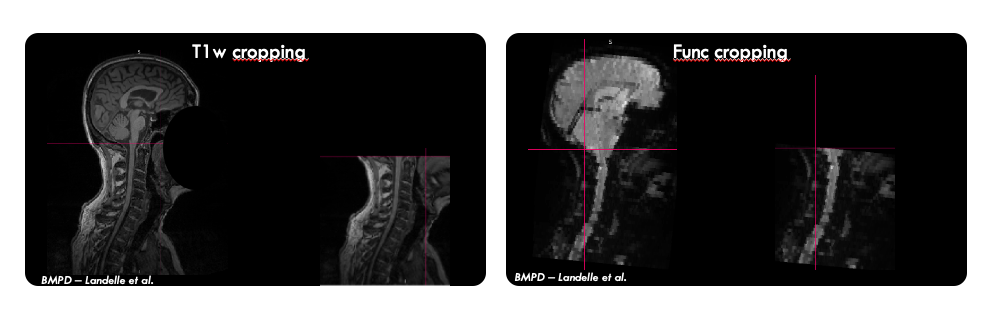

In [10]:
for sbj_nb in range(0,len(Directories['list_subjects'])):
    subject_name=Directories['list_subjects'][sbj_nb]
    layout_processed = BIDSLayout(Directories['OutputDir'] + 'sub-' + subject_name , validate=False) # processing derivatives
    layout = BIDSLayout(Directories['RawDataDir'] + 'sub-' + subject_name, validate=False) # processing derivatives

# III.1 Crop anat T1w ------------------------------------------------------------------------------------
    # Select files: 
    z_crop_T1w_brain=[163] # put the lower brain slice (should be one slice lower than the cerebellum)
    z_crop_T1w_SC=[164] # put one slice up to the spinal cord mark (upper C1 vertebra)
    anat_out= Directories['OutputDir'] + 'sub-' + subject_name + '/anat/'
    Files_T1w[subject_name]['SC']=anat_out + Files_T1w[subject_name]['Whole'].split('/')[-1].split('.')[0] + '_sc.nii.gz'
    
    if not os.path.exists(Files_T1w[subject_name]['SC']): #(
        print('Running brain & sc cropped for T1w: sub-' + subject_name)
        # Cropping function:
        run_proc('sct_crop_image -i {} -o {} -zmin {} -zmax {}'.format(Files_T1w[subject_name]['Whole'], Files_T1w[subject_name]['SC'], 0, z_crop_T1w_SC[1]))
        print('*************************************')
        print('sub-' + subject_name +' Brain & sc cropped for T1w: Done')
        print('*************************************')
    else:
        print('*************************************')
        print('Please delete the file ' + Files_T1w[subject_name]['SC'].split('/')[-1] + ' to redo the cropping step')

# III.2 Crop func -----------------------------------------------------------------------------------------------
    z_crop_SC=[36] # put the lower brain slice (should be one slice lower than the cerebellum)
    z_crop_brain=[33] # put one slice up to the spinal cord mark (upper C1 vertebra)
     # Select files:    
    for run in range(0,len(Directories['Runs'])):
        print(Files_func[subject_name]['SliceTiming'][run])
        OutputFolder_sc=SubDir_Out[subject_name] + Directories['Runs'][run] + '1_STC/spinalcord/'
        Func_stc_sc= OutputFolder_sc + Files_func[subject_name]['SliceTiming'][run].split('/')[-1].split('.')[0] + '_sc.nii.gz' #  output file
        Files_func_SC[subject_name]['Raw'][run]=Files_func[subject_name]['Raw'][run].split('/')[-1].split('.')[0] + '_sc.nii.gz'
    # Cropping function:
        if not os.path.exists(Func_stc_sc):#
            print('*************************************')
            print('Running sc cropped for func: sub-' + subject_name + ' ' + Directories['Runs'][run])
            run_proc('sct_crop_image -i {} -o {} -zmin {} -zmax {}'.format(Files_func[subject_name]['SliceTiming'][run], Func_stc_sc, 0, z_crop_SC[sbj_nb]))#z_crop_SC[0]))
            print('*************************************')
            print('sub-' + subject_name +' Brain & sc cropped for func: Done')
            print('*************************************')
        else:
            print('*************************************')
            print('Please delete the file ' + Func_stc_sc.split('/')[-1] + ' to redo the cropping step')
    
        Files_func_SC[subject_name]['SliceTiming'][run]=Func_stc_sc
            
        del Func_stc_sc, OutputFolder_sc,
    
Image("../illustration/III_BMPD_Cropping.png",width = 600, height = 300)

###  <font color=#2788AD> IV. Preprocessing step 3 : Spinal Cord Motion Correction </font>
###  <font color=#2788AD> IV.1 Mean func images & folder </font> <font color=#efb017> 

##### <font color=#00988c> **Outputs:**  </font>  
**A.Create 3 new folders in preprocessing folder:**  
- Coarse_mask  
- MOCO  
- QC_metrics  
    
**C. mean fMRI image :**    
- *stc_tmean.nii  => mean image after stc for the whole func image  
- *stc_sc_tmean.nii  => mean image after stc for the spinal cord  
- *stc_brain_tmean.nii  => mean image after stc for the brain  

*************************************
Please delate the file sub-P110_task-rest_bold_stc_sc_tmean.nii.gz to redo the mean image calculation


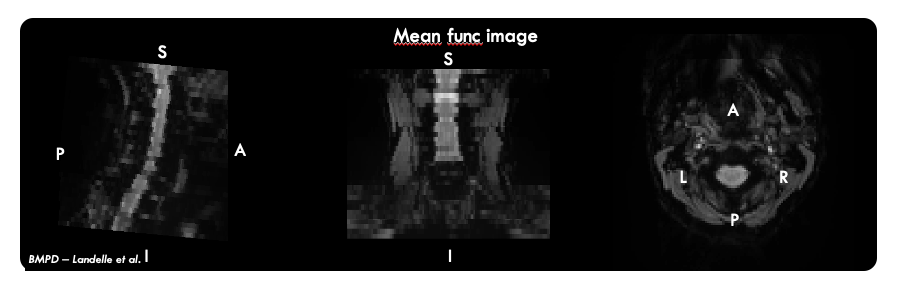

In [11]:
for subject_name in Directories['list_subjects']:
    layout_processed = BIDSLayout(Directories['OutputDir'] + 'sub-' + subject_name , validate=False) # processing derivatives
    layout = BIDSLayout(Directories['RawDataDir'] + 'sub-' + subject_name, validate=False) # processing derivatives
#_________________________________________________________________________    
# A. Create folders:
    for run in range(0,len(Directories['Runs'])):
        OutputFolder= SubDir_Out[subject_name] + Directories['Runs'][run] + '/'
        Coarse_mask_folder=OutputFolder + '2_Coarse_mask/'
        if not os.path.exists(Coarse_mask_folder):
            os.mkdir(Coarse_mask_folder)
            os.mkdir(Coarse_mask_folder + '/spinalcord/')
            print('Coarse_mask_folder created for sub-' + subject_name)
        
        MOCO_folder=OutputFolder + '3_MOCO/'
        if not os.path.exists(MOCO_folder):
            os.mkdir(MOCO_folder)
            os.mkdir(MOCO_folder + '/spinalcord')
            print('MOCO folders created for sub-' + subject_name)
    
        QC_mectrics_folder=SubDir_Out[subject_name] + 'QC_mectrics/'
        if not os.path.exists(QC_mectrics_folder):
            os.mkdir(QC_mectrics_folder)
        if not os.path.exists(QC_mectrics_folder + '/spinalcord/'):
            os.mkdir(QC_mectrics_folder + '/spinalcord/')
            print('QC_mectrics_folder created for sub-' + subject_name)
    del OutputFolder
#_________________________________________________________________________    
# B. Define input and output files:
    ext='.nii.gz'
    for run in range(0,len(Directories['Runs'])):
        STC_folder=SubDir_Out[subject_name] + Directories['Runs'][run] + '1_STC/'
        STC_folder_sc=SubDir_Out[subject_name] + Directories['Runs'][run] + '1_STC/spinalcord/'
                
        Func_stc = Files_func[subject_name]['SliceTiming'][run].split('/')[-1] #filename with extension, without path
        Func_stc_sc= Files_func_SC[subject_name]['SliceTiming'][run].split('/')[-1] #filename with extension , without path
        
#_________________________________________________________________________
# C. Calculate the mean fMRI image (spinal cord only)
        func_stc_sc_tmean = STC_folder_sc + Func_stc_sc.split('.')[0] + '_tmean' + ext #filename with extension, with path
        if not os.path.exists(func_stc_sc_tmean): #
            print('Calculate the mean fMRI images')
            run_proc('sct_maths -i {} -o {} -mean t'.format(STC_folder_sc + Func_stc_sc, func_stc_sc_tmean))
            print('*************************************')
            print('Calculate the mean fMRI image Done: ' + func_stc_sc_tmean.split('/')[-1] + ' & ' + func_stc_sc_tmean.split('/')[-1] + ' & ' + func_stc_brain_tmean.split('/')[-1])
            print('*************************************')
        else:
            print('*************************************')
            print('Please delate the file ' + func_stc_sc_tmean.split('/')[-1] + ' to redo the mean image calculation')
    
    del Func_stc, Func_stc_sc, STC_folder_sc
Image("../illustration/IV-I_BMPD_meanFunc.png",width = 600, height = 300)

### <font color=#2788AD> IV.2 Spinal Cord </font> <font color=#efb017> /!\  </font>  Manual step required
##### <font color=#00988c> **Steps :**  </font>   
1/ the volumes of each functional run were averaged (previous step) and   
2/ the centerline of the spinal cord was automatically extracted from the resulting image or can be draw manually when it is necessary  
3/ A cylindrical mask with a diameter of 15 mm along this centerline was drawn and further used to exclude regions outside the spinal cord from the motion correction procedure, as
those regions may move independently from the cord.   
4/ Motion correction was performed using the mean functional image as the target image and result in the motion corrected time series. Moco was carried out using slice-wise translations in the axial plane with non-linear registration (metric=MeanSquares) of all volumes to the first volume (num_target = 0)
The mean motion corrected image will be used for segmentation. 

##### <font color=#00988c> **Outputs:**  </font>  
**B : Automatique centerline image:** 2_Coarse_mask/spinalcord/X_tmean_centerline.nii and .csv  
**B : and Create sc mask image around the centerline :**  2_Coarse_mask/spinalcord/X_sc_tmean_seg.nii   
**C : MOCO:** *slice-wise: Poly=0, mean squares as cost function and + bspline as interpolation metric*
- Motion corrected volumes: *_sc_moco.nii & one temporary file for each volume
- Time average of corrected vols: *_sc_moco_mean.nii
- Time-series with 1 voxel in the XY plane: *_sc_moco_params_X.nii & params_Y.nii
- Slice-wise average of MOCO for XY : moco_params.tsv & moco_params.txt

**D : Motion Params and outliers**
- FD: Calculate the derivatives of x and y (abs difference of displacement between each volumes): sub-SXX/func/QC_metrics/spinalcord/Diff_displacement_XXX_sc.txt 

*************************************
Please delate the file sub-P110_task-rest_bold_stc_sc_tmean_seg.nii.gz to redraw the manual mask creation
*************************************
Please delete the file sub-P110_task-rest_bold_stc_sc_moco.nii.gz to redo the MOCO
*************************************
Do FD calculation: P110
*************************************
Differencial displacement (should not exeed 0.2 mm)
Diff_X: 0.061 mm
Diff_Y: 0.113 mm


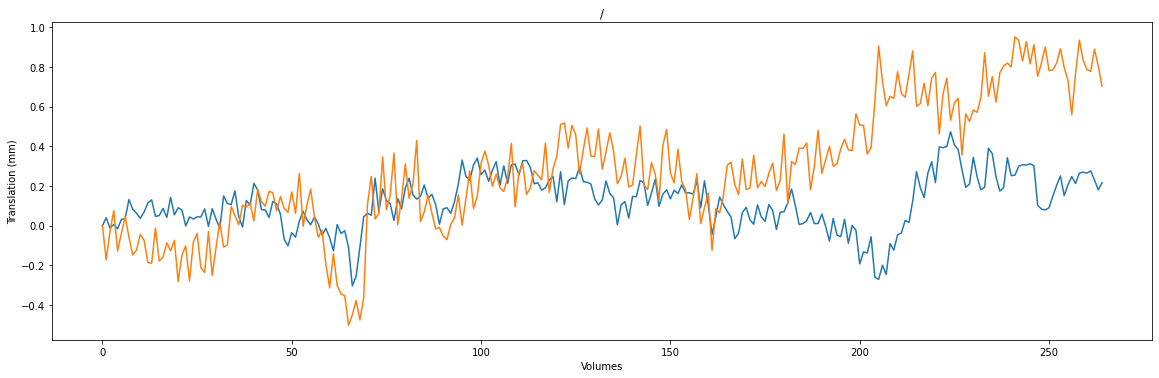

In [12]:
for subject_name in Directories['list_subjects']:
    layout_processed = BIDSLayout(Directories['OutputDir'] + 'sub-' + subject_name , validate=False) # processing derivatives
    layout = BIDSLayout(Directories['RawDataDir'] + 'sub-' + subject_name, validate=False,ignore=[re.compile('func/.*_physio.json')]) # processing derivatives

    Files_func_SC[subject_name]['MOCO']['coarsemask']={}
    Files_func_SC[subject_name]['MOCO']['params']={}
    Files_func_SC[subject_name]['MOCO']['func_moco']={}
    Files_func_SC[subject_name]['MOCO']['func_moco_mean']={}
#_______________________________________________________________________    
# A. Define input and output files:
    ext='.nii.gz'
    QC_mectrics_folder=SubDir_Out[subject_name] + 'QC_mectrics/spinalcord/'
    fig, axs = plt.subplots(1,len(Directories['Runs']), figsize=(16, 5), facecolor='w', edgecolor='k')
    fig.tight_layout()
    
    for run in range(0,len(Directories['Runs'])):
        Folder= SubDir_Out[subject_name] + Directories['Runs'][run]
        InputFolder=Folder + '1_STC/spinalcord/'
        MOCO_folder=Folder + '3_MOCO/spinalcord/'
        Coarse_mask_folder=Folder + '2_Coarse_mask/spinalcord/'
    
        Func_stc = Files_func[subject_name]['SliceTiming'][run].split('/')[-1] #filename with extension, without path
        Func_stc_sc= Files_func_SC[subject_name]['SliceTiming'][run].split('/')[-1] #filename with extension , without path
        func_stc_tmean = InputFolder + Func_stc.split('.')[0] + '_tmean' + ext #filename with extension, with path
        func_stc_sc_tmean = InputFolder + Func_stc_sc.split('.')[0] + '_tmean' + ext #filename with extension, with path
        im_stc_sc_func=nb.load(InputFolder + Func_stc_sc)
        nb_volumes = im_stc_sc_func.shape[3]
        func_stc_sc_centerline = Coarse_mask_folder + Func_stc_sc.split('.')[0] + '_tmean_centerline'  #filename without extension, with path

#_________________________________________________________________________   
# B. Create manual coarse mask around sc using func image 
        func_sc_mask = Coarse_mask_folder + func_stc_sc_tmean.split('/')[-1].split('.')[0] + '_seg' + ext #filename with extension, with path
        radius_mask = 15  # 15 radius in mm of the mask in 3D plane between 10 and 15 depending on surrounding structures
    
        if not os.path.exists(func_sc_mask):
            print('Start auto centerline and mask subject: ' + subject_name)
            #B.1 Create the centerline, if manual centerline is needed change: -method optic by -method viewer
            run_proc('sct_get_centerline -i {} -o {} -c t1 -method viewer -centerline-algo bspline'.format(func_stc_sc_tmean,func_stc_sc_centerline)) #viewer #optic
            #B.2 Create the mask around the centerline
            run_proc('sct_create_mask -i {} -p centerline,{} -size {} -o {}'.format(func_stc_sc_tmean,func_stc_sc_centerline + '.nii.gz' ,radius_mask, func_sc_mask))
            print('*************************************')
            print('Manual segmentation Done for subject: ' + subject_name)
            print('WARNING: check the mask output, and, if necessary, do centerline manually.')
            print('*************************************')
        else:
            print('*************************************')
            print('Please delate the file ' + func_sc_mask.split('/')[-1] + ' to redraw the manual mask creation')

            #_________________________________________________________________________       
# C. MOtion COrrection (MOCO)
        num_target = 0 # Target volume 
        params_moco = 'poly=0,smooth=1,metric=MeanSquares,gradStep=1,sampling=0.2'#,numTarget=' + str(num_target)
        param_group = 1 # Group nvols successive fMRI volumes for more robustness. Default value = 1
        func_sc_moco = MOCO_folder + Func_stc_sc.split('/')[-1].split('.')[0] + '_moco' + ext
        func_sc_moco_mean = MOCO_folder + Func_stc_sc.split('/')[-1].split('.')[0] + '_moco_mean' + ext
        params_tsv=MOCO_folder + 'moco_params.tsv' #MOCO_folder +'moco_params.tsv'
        params_txt=params_tsv.split('.')[0] + '.txt'
        
        if not os.path.exists(func_sc_moco):#
            # 2D slice-wise: mean squares as cost function and + nn as interpolation metric
            run_proc('sct_fmri_moco -i {} -m {} -param {} -ofolder {}  -x spline -g {} -r 1'.format(InputFolder + Func_stc_sc, func_sc_mask, params_moco, MOCO_folder, param_group))
            # delate temporary folder  >>>>> /!\ change the path here <<<<<<
            run_proc('find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
            
            #MOCO_folder +'moco_params.txt'
            data=pd.read_csv(params_tsv, '\t')
            data.to_csv(params_txt,index=False, header=None)
            print('*************************************')
            print('MOCO Done on subject: ' + subject_name + '  ' + Directories['Runs'][run])
            print('*************************************')
        else:
            print('*************************************')
            print('Please delete the file ' + func_sc_moco.split('/')[-1] + ' to redo the MOCO')
        
        params_data=pd.read_csv(params_txt, ',', header=None)
        
        fig.subplots_adjust(hspace = .5, wspace=.001)
        #axs = axs.ravel()
        axs.plot(params_data[0]) # add axs[] if more than one run
        axs.plot(params_data[1])
        axs.set_title(Directories['Runs'][run])
        
        if run==0:
            axs.set_ylabel("Translation (mm)")
            axs.set_xlabel("Volumes")
#_________________________________________________________________________       
# D. Motion parameters ouliers DVARS and FD 

        if not os.path.exists(QC_mectrics_folder + 'Diff_displacement_' + Directories['Runs'][run] + '_sc.txt'): #(''):#
            print('*************************************')
            print('Do FD calculation: ' + subject_name)
            # Calculate the derivatives of x and y (abs difference of displacement between each volumes) 
            diff_X = np.abs(np.diff(params_data[0]))
            diff_Y = np.abs(np.diff(params_data[1]))
            meandiff=[np.mean(diff_X),np.mean(diff_Y)]
            print('*************************************')
            print('Differencial displacement (should not exeed 0.2 mm)')
            print('Diff_X: ' + str(round(meandiff[0],3)) + ' mm')
            print('Diff_Y: ' + str(round(meandiff[1],3)) + ' mm')
            
            #run_proc('fsl_motion_outliers -i {} -o {} -s {} -p {} --dvars'.format(func_sc_moco, QC_mectrics_folder + '/sub-'+subject_name+'_dvars_outliers.txt', QC_mectrics_folder + '/sub-'+subject_name+'_dvars.txt',QC_mectrics_folder + '/sub-'+subject_name+'_dvars.png'))
            if os.path.exists(MOCO_folder + 'moco_params_outliers_1mm.txt'):
                os.remove(MOCO_folder + 'moco_params_outliers_1mm.txt') # remove this file
            
            np.savetxt(QC_mectrics_folder + 'Diff_displacement_'  + '_sc.txt', meandiff)
            del diff_X, diff_Y, meandiff
        #_________________________________________________________________________
# E. Save filenames in the main dictionnaries
        
        Files_func_SC[subject_name]['MOCO']['coarsemask'][run]=func_sc_mask
        Files_func_SC[subject_name]['MOCO']['params'][run]=params_txt
        Files_func_SC[subject_name]['MOCO']['func_moco'][run]=func_sc_moco
        Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run]=func_sc_moco_mean


        
        del Func_stc, Func_stc_sc, func_stc_tmean, func_stc_sc_tmean, im_stc_sc_func, nb_volumes, func_sc_mask, params_moco, param_group
        
        
    plt.savefig(QC_mectrics_folder  + 'Diff_displacement_sc.png', dpi=100, bbox_inches = 'tight')
    
        
    del subject_name, radius_mask, num_target


###  <font color=#2788AD> V. Preprocessing step 5 : Segmentation </font>


###  <font color=#2788AD> V.1 Spinal Cord T1w and Segmentation </font> 
### <font color=#efb017> /!\  </font>  Manual step required

##### <font color=#00988c> **A. T1w segmentation + visual inspection and manual correction if needed** </font>
> Spinal cord segmentation: WM + GM: *T1w/segmentation/X_desc-T1w_space-orig_label-sc_mask.nii.gz*  => Manual correction if needed
CSF segmentation : *T1w/segmentation/X_-sc_CSF_seg.nii.gz* =>  Manual correction if needed
Cord segmentation (WM + Gm + CSF): *T1w/segmentation/X_-sc_cord_seg.nii.gz*
Anat' cropped: anat/X_T1w_sc_croppedXY.nii  
    
##### <font color=#00988c> **B. T1w Labelisation** </font>  
> T1w labelisation: *T1w/segmentation/X_desc-T1w_space-orig_label-ivd_mask.nii.gz*

##### <font color=#00988c> **C. Functionnal segmentation**: segmentation + visual inspection and manual correction if needed</font>
> Func centerline: *_sc_moco_mean_centerline.nii.gz*  
Func segmentation GM + CSF + WM: *func/'task'/4_Segmentation/spinalcord/X_sc_moco_mean_seg.nii.gz*  
Func cropped: *func/'task'/3_MOCO/spinalcord/X_sc_moco_mean_croppedXY.nii.gz*

nb: we Cropped Functionnal moco and T1w images in XY to reduce the size of the image for the coreg step

The outputs should be inspect visually and correct manually if needed (using fsleyes for exemple)


********************************************
T1w seg already exist for: sub-P110
********************************************
Cropping of T1w done for: sub-P110
********************************************
********************************************
T1w manual labeling already done for: sub-P110
********************************************
*************************************
Please delate the file sub-P110_task-rest_bold_stc_sc_moco_mean_seg.nii.gz to redraw the manual segmentation


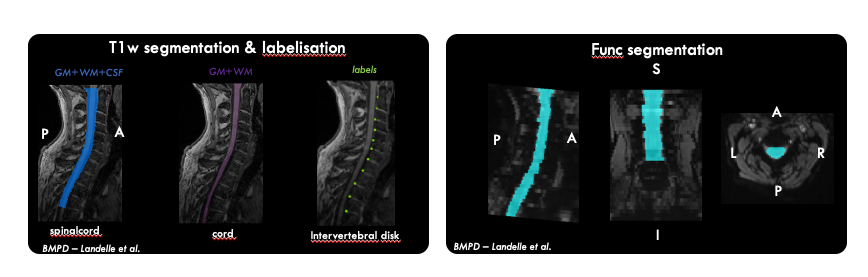

In [14]:
for subject_name in Directories['list_subjects']:
    if not os.path.exists(Directories['OutputDir'] + 'sub-' + subject_name + '/anat/T1w_seg_CSF'):
        os.mkdir(Directories['OutputDir'] + 'sub-' + subject_name + '/anat/T1w_seg_CSF')    
        print('anat out folders created')
            
    Files_func_SC[subject_name]['CroppedXY']={}
#________________________________________________________________________________________________
# A. Segmentation of T1w image
    out_T1w= Directories['OutputDir'] + 'sub-' + subject_name + '/anat/T1w_seg_CSF/'
    Files_T1w[subject_name]['SC_seg']=out_T1w + Files_T1w[subject_name]['SC'].split('/')[-1].split('.')[0].split('_T1w')[0] + '_desc-T1w_space-orig_label-sc_mask.nii.gz'
    T1w_sc_CSF=out_T1w + Files_T1w[subject_name]['SC'].split('/')[-1].split('.')[0] + '_rescaled_CSF_seg.nii.gz'
    Files_T1w[subject_name]['SC_cord']=out_T1w + Files_T1w[subject_name]['SC'].split('/')[-1].split('.')[0] + '_rescaled_cord_seg.nii.gz'

    if not os.path.exists(Files_T1w[subject_name]['SC_seg']):
        print('********************************************')
        print('Run T1w seg for: sub-' + subject_name)
        method='propseg'#'propseg' #'deepseg'
        if method == 'propseg':
            run_proc('sct_propseg -i {}  -c t1 -ofolder {}'.format(Files_T1w[subject_name]['SC'], out_T1w))
        elif method == 'deepseg':
            run_proc('sct_deepseg_sc -i {} -c t1 -ofolder {}'.format(Files_T1w[subject_name]['SC'], out_T1w))
        # renaming the segmentation file to follow the bids specification
        T1w_sc_seg = out_T1w + Files_T1w[subject_name]['SC'].split('/')[-1].split('.')[0] +'_seg.nii.gz' #default output
        os.rename(T1w_sc_seg, Files_T1w[subject_name]['SC_seg'])
        
        #Create cord mask: WM + GM +CSF
        run_proc('fslmaths {} -add {} {}'.format(Files_T1w[subject_name]['SC_seg'],T1w_sc_CSF, Files_T1w[subject_name]['SC_cord']))
        
        print('WARNING: Please check the quality of the spinal cord segmentation and, if necessary, correct it.')
        print('Place the manually-corrected file into the "manual" derivative, using the same BIDS structure as the "rawdata" folder and keeping the same name.')
        print('********************************************')
    else:
        print('********************************************')
        print('T1w seg already exist for: sub-' + subject_name)
        print('********************************************')
    
    #Crop T1w image to reduce is weight
    Files_T1w[subject_name]['SC_CroppedXY']=Files_T1w[subject_name]['SC'].split('.')[0] + '_croppedXY.nii.gz'
    
    if not os.path.exists(Files_T1w[subject_name]['SC_CroppedXY']):
        run_proc('sct_crop_image -i {} -o {} -xmin 62 -xmax 120 -ymin 40 -ymax 160'.format(Files_T1w[subject_name]['SC'],Files_T1w[subject_name]['SC_CroppedXY']))
    print('Cropping of T1w done for: sub-' + subject_name)
    print('********************************************')
#_______________________________________________________________________________________________
# C. Labelisation of the intervertebral discs on the T1w image
# Currently, this function does not label the vertebrae and require to do so manually.
    T1w_ivd =Directories['OutputDirManual'] + 'sub-' + subject_name  + '/anat/' + Files_T1w[subject_name]['SC'].split('/')[-1].split('.')[0].split('_T1w')[0]  + '_desc-T1w_space-orig_label-ivd_mask.nii.gz'
    if not os.path.exists(T1w_ivd):  
        run_proc('sct_label_utils -i {} -o {} -create-viewer 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15'.format(Files_T1w[subject_name]['SC'],T1w_ivd))
        print('T1w manual labeling done for: sub-' + subject_name)
        print('********************************************')
    else:
        print('********************************************')
        print('T1w manual labeling already done for: sub-' + subject_name)
        print('********************************************')

#_______________________________________________________________________________________________
# D. Functionnal segmentation and crop the image
    for run in range(0,len(Directories['Runs'])):
        Files_func_SC[subject_name]['CroppedXY']['func_moco']={}
        Files_func_SC[subject_name]['CroppedXY']['func_moco_mean']={}
        OutputFolder= SubDir_Out[subject_name] + Directories['Runs'][run] + '4_Segmentation/'
        Segmentation_folder=OutputFolder + 'spinalcord/'
        if not os.path.exists(OutputFolder):
            os.mkdir(OutputFolder)
        if not os.path.exists(Segmentation_folder):
            os.mkdir(Segmentation_folder)
        
        Files_func_SC[subject_name]['Seg'][run]=Segmentation_folder + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1].split('.')[0] + '_seg' + ext
        Func_centerline=Files_func_SC[subject_name]['MOCO']['coarsemask'][run].split('_seg')[0] + '_centerline.nii.gz' 
    
        if not os.path.exists(Files_func_SC[subject_name]['Seg'][run]):
            print('Start automatic segmentation subject: ' + subject_name)
            #run_proc('sct_propseg -i {} -ofolder {} -init-centerline viewer -radius 8 -max-deformation 100 -min-contrast 0 -c t2s -max-area 500'.format(Files_func_SC[subject_name]['MOCO']['fname_func_sc_moco_mean'],SubDir_Out[subject_name]))
            run_proc('sct_propseg -i {} -ofolder {} -init-centerline {} -radius 8 -max-deformation 100 -min-contrast 0 -c t1 -max-area 500'.format(Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run], Segmentation_folder, Func_centerline))
            print('*************************************')
            print('Manual segmentation Done for subject: ' + subject_name)
            print('WARNING: check the segmentation output, and, if necessary, do it manually.')
            print('*************************************')
        else:
            print('*************************************')
            print('Please delate the file ' + Files_func_SC[subject_name]['Seg'][run].split('/')[-1] + ' to redraw the manual segmentation')
        
        Files_func_SC[subject_name]['CroppedXY']['func_moco'][run]=Files_func_SC[subject_name]['MOCO']['func_moco'][run].split('.')[0] + '_croppedXY.nii.gz'
        Files_func_SC[subject_name]['CroppedXY']['func_moco_mean'][run]=Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('.')[0] + '_croppedXY.nii.gz'

        if not os.path.exists(Files_func_SC[subject_name]['CroppedXY']['func_moco_mean'][run]):
            run_proc('sct_crop_image -i {} -o {} -xmin 40 -xmax 75 -ymax 90'.format(Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run],Files_func_SC[subject_name]['CroppedXY']['func_moco_mean'][run]))
            run_proc('sct_crop_image -i {} -o {} -xmin 40 -xmax 75 -ymax 90'.format(Files_func_SC[subject_name]['MOCO']['func_moco'][run],Files_func_SC[subject_name]['CroppedXY']['func_moco'][run]))

        del Func_centerline
        
Image("../illustration/V_BMPD_segmentation.png",width = 600, height = 300)

###  <font color=#2788AD> VI. Preprocessing step 6: Co-registration </font>

###  <font color=#2788AD> VI.1 Spinal cord : T1w and func coregistration</font> 
##### <font color=#00988c> **A. Coregistration PAM50 and T1w** using spine segmentation and labels </font> 
**T1w to PAM50:**  in anat/T1w_sc_coreg_new_CL folder
> warp from T1w to PAM50: sub-PXXX_from-T1w_to-PAM50_mode-image_xfm.nii.gz
> warp from PAM50 to T1w: sub-PXXX_from-PAM50_to-T1w_mode-image_xfm.nii.gz
> Image T1w in PAM50: anat2template.nii.gz
> Image PAM50 in T1w: template2anat.nii.gz

**Generate template:** in anat/T1w_sc_coreg_new_CL folder
> template_in_T1w_CL: template folder in T1w space



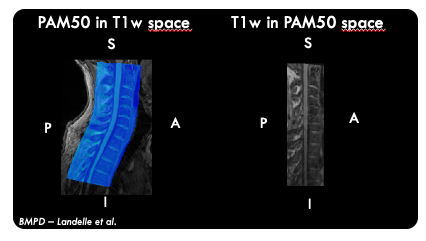

In [15]:
for subject_name in Directories['list_subjects']:
    
# A. Generate the template in T1w space _____________________________________________________
    # create new folder for coregistration
    CoregDir=Directories['OutputDir'] + 'sub-' + subject_name + '/anat/T1w_sc_coreg_new_CL/'
    if not os.path.exists(CoregDir):
        os.mkdir(CoregDir)
        
    #inputs (first check in manual folder):
    if os.path.exists(Directories['OutputDirManual'] + 'sub-' + subject_name + '/anat/' + Files_T1w[subject_name]['Whole'].split('/')[-1].split('T1w')[0] + 'desc-T1w_space-orig_label-sc_mask.nii.gz'):
        T1w_sc_seg=Directories['OutputDirManual'] + 'sub-' + subject_name + '/anat/' + Files_T1w[subject_name]['Whole'].split('/')[-1].split('T1w')[0] + 'desc-T1w_space-orig_label-sc_mask.nii.gz'
    else: # choose automatic segmentation
        T1w_sc_seg=Directories['OutputDir'] + 'sub-' + subject_name + '/anat/T1w_seg_CSF/' + Files_T1w[subject_name]['Whole'].split('/')[-1].split('T1w')[0] + 'desc-T1w_space-orig_label-sc_mask.nii.gz'

    T1w_ivd=Directories['OutputDirManual'] + 'sub-' + subject_name + '/anat/' + Files_T1w[subject_name]['Whole'].split('/')[-1].split('T1w')[0] + 'desc-T1w_space-orig_label-ivd_mask.nii.gz'
 
    #outputs:
    template_out= CoregDir + '/template_in_T1w'
    warp_from_T1w_to_PAM50 = CoregDir + 'sub-'  + subject_name + '_from-T1w_to-PAM50_mode-image_xfm.nii.gz'
    warp_from_PAM50_to_T1w = CoregDir + 'sub-'  + subject_name + '_from-PAM50_to-T1w_mode-image_xfm.nii.gz'
    T1w_in_PAM50= CoregDir + 'anat2template.nii.gz'
    PAM50_in_T1w=CoregDir + 'template2anat.nii.gz'
    
    #warp the template in T1w space using T1w spinal segmentation and labels and rename the outputs
    if not os.path.exists(template_out):
        run_proc('sct_register_to_template -i {} -s {} -ldisc {} -ofolder {}'.format(
            Files_T1w[subject_name]['SC'], # T1w image (input)
            T1w_sc_seg,  # T1w spinal segmentation 
            T1w_ivd, # T1w labels
            CoregDir)) # outputs Folder
        os.rename(os.path.join(CoregDir, "warp_anat2template.nii.gz"), warp_from_T1w_to_PAM50)
        os.rename(os.path.join(CoregDir, "warp_template2anat.nii.gz"), warp_from_PAM50_to_T1w)

        # create the template in the corresponding output folder
        run_proc('sct_warp_template -d {} -w {} -s 1 -ofolder {}'.format(
            Files_T1w[subject_name]['SC'],
            warp_from_PAM50_to_T1w,
            template_out))

#________________________________________________________________________________________________
# B. Use CSF+seg from T2 template image and check the output and correct it manually
        run_proc('fslmaths {} -add {} {}'.format(template_out + '/template/PAM50_cord.nii.gz',template_out + '/template/PAM50_csf.nii.gz', template_out + '/template/PAM50_csfwmgm.nii.gz'))
       
        
Image("../illustration/VI-1_BMPD_Co-reg_anat.png",width = 600, height = 300)


##### <font color=#00988c> **B. Coregistration functional images and PAM50_t1** using CSF segmentation </font> 
> warp from func to PAM50_t2s:  */5_Coregistration/spinalcord/xxx_from-func_to-template_mode-image_xfm.nii.gz*  
> warp from PAM50_t2s in T1w to func:  */5_Coregistration/spinalcord/xxx_from-template_to-func_mode-image_xfm.nii.gz*   

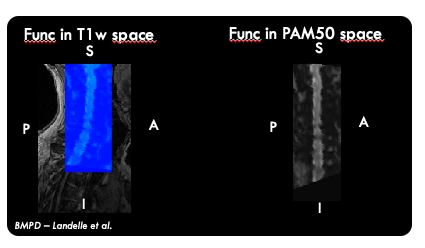

In [18]:
for subject_name in Directories['list_subjects']:
    
    Files_func_SC[subject_name]['Coreg']['func_mean_reg']={}
    Files_func_SC[subject_name]['Coreg']['func_reg']={}
   
    # A. Create output folder:___________________________________________________________________________
    Coreg_folder=Directories['OutputDir'] + 'sub-' + subject_name + '/func/' + Directories['Runs'][run] + '5_Coregistration/'
    if not os.path.exists(Coreg_folder):
        os.mkdir(Coreg_folder)
        os.mkdir(Coreg_folder + 'spinalcord/')
        print('Coreg_folder created for sub-' + subject_name)
        
    Func_in_T1w =  Coreg_folder + 'spinalcord/' + Files_func_SC[subject_name]['MOCO']['func_moco'][run].split('/')[-1].split('.')[0] + '_coreg_in_T1w.nii.gz'
    Func_mean_in_template_old =  Coreg_folder +  'spinalcord/' + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1].split('.')[0] + '_coreg_in_template.nii.gz'
    warp_from_func_to_T1w= Coreg_folder + 'spinalcord/' + 'sub-'  + subject_name + '_from-func_to-T1w_mode-image_xfm.nii.gz'
    params_func_to_T1w = 'step=1,type=seg,algo=centermass,metric=MeanSquares:step=2,algo=bsplinesyn,type=seg,slicewise=1,iter=3'
    
    Func_mean_in_T1w =  Coreg_folder +  'spinalcord/' + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1].split('.')[0] + '_coreg_in_T1w.nii.gz'
   
        
    if not os.path.exists(Func_mean_in_T1w):
        #run registration of the mean func image to the template in T1w use the output warping field
        run_proc('sct_register_multimodal -i {} -d {} -iseg {} -dseg {} -param {} -o {} -owarp {} -x spline'.format(Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run], # input = mean func image
                                                                                                                template_out + '/template/PAM50_t2s.nii.gz', # template T2s = destination image
                                                                                                                Files_func_SC[subject_name]['Seg'][run], # Seg CSF func image
                                                                                                                template_out + '/template/PAM50_csfwmgm.nii.gz', # PAM50_cord = PAM50 segmentation : spinal cord + csf
                                                                                                                params_func_to_T1w,
                                                                                                                Func_mean_in_T1w, # ouput: mean func coregister in PAM50 in T1w
                                                                                                                warp_from_func_to_T1w # output warping field
                                                                                                                ))
        
        input2=Coreg_folder +  'spinalcord/warp_PAM50_t2s2' + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1]
        output2=Coreg_folder +  'spinalcord/warp_T1w_2' + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1]
        os.rename(input2,output2)  
    
    #B. Concatenate warp from func_to_T1w and from T1w_to_PAM50
    warp_from_func_to_T1w_to_PAM50=Coreg_folder + 'spinalcord/' + 'sub-'  + subject_name + '_from-func_to_T1w_to_PAM50_mode-image_xfm.nii.gz'

    
    # Select the template => Please change the path
    PAM50_T2s='/cerebro/cerebro1/dataset/bmpd/derivatives/Func_analyses/Templates/PAM50/template/PAM50_t2_C1T2.nii.gz'
            
    if not os.path.exists(warp_from_func_to_T1w_to_PAM50):
        run_proc('sct_concat_transfo -d {} -w {} {} -o {}'.format(PAM50_T2s,warp_from_func_to_T1w,warp_from_T1w_to_PAM50,warp_from_func_to_T1w_to_PAM50))
    
      
    
    Func_mean_in_PAM50 = Coreg_folder + 'spinalcord/' + Files_func_SC[subject_name]['MOCO']['func_moco_mean'][run].split('/')[-1].split('.')[0] + '_coreg_in_PAM50.nii.gz'
       
     #________________________________________________________________________________________________
# C . Apply warp_func_to_PAM50 to func
    #. 1 Apply to the mean image => ouput in the PAM50 resolution (very high)   
    if not os.path.exists(Func_mean_in_PAM50):    
        # delate temporary folder  >>>>> /!\ change the path here <<<<<<
        run_proc('find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
        run_proc('find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
        run_proc('sct_apply_transfo -i {} -d {} -o {} -w {} -r 0 -v 2'.format(Files_func_SC[subject_name]['CroppedXY']['func_moco_mean'][run], # input = func image
                                                                            PAM50_T2s, # destination image is func because we want to keep the same resolution
                                                                          Func_mean_in_PAM50, # ouput: func coregister in PAM50 in T1w
                                                                        warp_from_func_to_T1w_to_PAM50 # warping field to apply
                                                                          ))
        
Image("../illustration/VI-2_BMPD_Co-reg_func.png",width = 600, height = 300)
